# **Social Media Mining - Assignment 3**

在作業2中，我們使用PyTorch Geometric提供的GCN layer `GCNConv`建構了GNN模型。在這次作業中我們將直接實作**GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)) 和 **GAT** ([Veličković et al. (2018)](https://arxiv.org/abs/1710.10903)) 層。然後，我們需要在CORA資料集上運行模型，測試其效果。CORA是一個學術論文引用網絡資料集，經常被用來測試模型效果。

***請勿參考網路上的相關實作，也不能copy同學的code。**但你可以與同學或TA討論你遇到的問題。

In Assignment 3 we constructed GNN models by using PyTorch Geometric built in GCN layer, the `GCNConv`. In this assignment we will implement the **GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)) and **GAT** ([Veličković et al. (2018)](https://arxiv.org/abs/1710.10903)) layers directly. Then we will run our models on the CORA dataset, which is a standard citation network benchmark dataset.

***Please do not refer to the related work on the web or copy from classmates.** But You can discuss your problems with your classmates or TA.

# 設備 Device

如果你使用Colab，請調整至GPU模式。

If you are using Colab, please adjust to GPU mode

## 安裝 Installation

In [1]:
import torch
import os
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 2.2.1+cu121


In [2]:
# 確保下載的CUDA版本與上面一致
# Make sure the CUDA version you download is the same as above
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
!pip install -q torch-geometric

In [3]:
import torch_geometric
torch_geometric.__version__

'2.5.3'

# 實作Layer模塊 Implementing Layer Modules

在作業2中，我們在節點和圖分類任務中使用GCN實現了一個圖神經網絡模型。但是，我們在作業2中使用的GCN模塊是官方庫提供的。這次的作業中，我們將提供一個通用的圖神經網絡棧，你可以在此插入自己實作的GraphSAGE和GAT的模塊。然後，你需要使用自己實作的模塊來完成CORA的節點分類任務。在這個數據集中，節點對應文檔，邊對應無向引用。每個節點都有一個類別標籤。節點特徵是文件的詞袋表示。對於Cora數據集，有2708個節點，5429條邊，7個預測類的節點，以及每個節點的1433個特徵。

In assignment 2, we implemented a network using GCN in node and graph classification tasks. However, the GCN module we used in assignment 2 is from the official library. For this problem, we will provide you with a general Graph Neural Network Stack, where you'll be able to plugin your own modules of GraphSAGE and GATs. We will use our implementations to complete node classification on CORA, which is a standard citation network benchmark dataset. In this dataset, nodes correspond to documents and edges correspond to undirected citations. Each node has a class label. The node features are elements of a bag-or-words representation of a document. For the Cora dataset, there are 2708 nodes, 5429 edges, 7 prediction classes for nodes, and 1433 features per node.

## GNN棧模塊 GNN Stack Module

下面是一個通用的GNN模塊，可以插入任何層，包括 GraphSage、GAT 等。你需要使用自己的 GraphSage 和 GAT 層作為 GNNStack 模塊的組件。如果不使用multi-head attention，下方code不需改動。

Below is the implementation for a general GNN Module that could plugin any layers, including **GraphSage**, **GAT**, etc. This module is provided for you, and you own **GraphSage** and **GAT** layers will function as components in the GNNStack Module.

In [4]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(args.heads * hidden_dim, hidden_dim), nn.Dropout(args.dropout),
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GAT':
            return GAT

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout)

        x = self.post_mp(x)

        if self.emb == True:
            return x

        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

## GraphSage

你需要實現**forward**、**message**和**aggregate**函數。**forward**函數是進行實際資訊傳遞的地方。每次迭代中的所有邏輯都發生在**forward**中，我們將調用**propagate（傳播）**函數將資訊從鄰居節點傳播到中心節點。因此，一般的範式是前處理->傳播->後處理(update)。

**propagate（傳播）**(在MessagePassing Class中已經實作好，不需要自己寫)會自動調用**message**，將鄰居節點的資訊轉化為**messages**，並調用**aggregate**，將鄰居節點的所有資訊聚合為一個。 forward的輸出正是當前迭代後的Embedding。

此外，傳遞給propagate()的tensors可以通過在變量名後面加上_i或_j來映射到各自的節點i和j，.例如x_i和x_j。請注意，我們一般把i稱為中心節點，把j稱為鄰居節點，這是最常用的符號表示。

需要注意的是，我們的GraphSage添加了額外的**skip connections（殘差連接）**作為update function，也就是下方公式：

\begin{equation}
h_v^{(l)} = W_l\cdot h_v^{(l-1)} + W_r \cdot AGG(\{h_u^{(l-1)}, \forall u \in N(v) \})
\end{equation}

為了簡便，我們使用平均聚合：

\begin{equation}
AGG(\{h_u^{(l-1)}, \forall u \in N(v) \}) = \frac{1}{|N(v)|} \sum_{u\in N(v)} h_u^{(l-1)}
\end{equation}

此外，每次迭代後都會進行ℓ-2歸一化。

為了正確完成工作，我們必須了解不同函數之間的相互作用。在propagate中，我們可以傳入任何我們想要的參數。例如，我們把x作為一個參數傳入：

... = propagate(..., $x$=($x_{central}$, $x_{neighbor}$), ...)

這裡 $x_{central}$ 和 $x_{neighbor}$ 代表作為中心節點和作為鄰居節點時節點的特徵。如果兩者表示相同，那麼$x_{central}$和$x_{neighbor}$是一樣的。假設$x_{central}$和$x_{neighbor}$的形狀都是N*d，其中N是節點數，d是特徵的維度。

在Message函數中，我們可以獲得名為x_i和x_j的參數。通常x_i代表 "中心節點"，而x_j代表 "鄰居節點"。注意這裡的形狀：x_i和x_j都是E*d的形狀（不是N！）。 x_i是通過我們在propagate中傳遞的$x_{central}$的查找，將所有邊的中心節點的嵌入連接起來得到的。類似地，x_j是通過從我們在propagate中傳遞的$x_{neighbor}$中查找，將所有邊的鄰居節點的嵌入連接起來而得到的。

舉個例子。假設我們有4個節點，所以$x_{central}$和$x_{neighbor}$形狀是4*d，我們有兩條邊（1，2）和（3，0）。因此，x_i由$[x_{central}[1]^T; x_{central}[3]^T]^T$得到，而x_j由$[x_{neighbor}[2]^T; x_{neighbor}[0]^T]^T$得到。

---

You will be implementing the **forward**, **message** and **aggregate** functions. Generally, the **forward** function is where the actual message passing is conducted. All logic in each iteration happens in **forward**, where we'll call **propagate** function to propagate information from neighbor nodes to central nodes.  So the general paradigm will be pre-processing -> propagate -> post-processing(update).

**propagate**(It is already implemented in MessagePassing Class, so you don't need to write it yourself.) further calls **message** which transforms information of neighbor nodes into messages and **aggregate** which aggregates all messages from neighbor nodes into one. The output of **forward** is exactly the embeddings after the current iteration.

In addition, tensors passed to **propagate()** can be mapped to the respective nodes $i$ and $j$ by appending _i or _j to the variable name, .e.g. x_i and x_j. Note that we generally refer to $i$ as the central nodes that aggregates information, and refer to $j$ as the neighboring nodes, since this is the most common notation.

One thing to note is that we're adding **skip connections** to our GraphSage. Formally, the update rule for our model is described as below:

\begin{equation}
h_v^{(l)} = W_l\cdot h_v^{(l-1)} + W_r \cdot AGG(\{h_u^{(l-1)}, \forall u \in N(v) \})
\end{equation}

For simplicity, we use mean aggregations where:

\begin{equation}
AGG(\{h_u^{(l-1)}, \forall u \in N(v) \}) = \frac{1}{|N(v)|} \sum_{u\in N(v)} h_u^{(l-1)}
\end{equation}

Additionally, $\ell$-2 normalization is applied after each iteration.

In order to complete the work correctly, we have to understand how the different functions interact with each other. In **propagate** we can pass in any parameters we want. For example, we pass in $x$ as an parameter:

... = propagate(..., $x$=($x_{central}$, $x_{neighbor}$), ...)

Here $x_{central}$ and $x_{neighbor}$ represent the features from **central** nodes and from **neighbor** nodes. If we're using the same representations from central and neighbor, then $x_{central}$ and $x_{neighbor}$ could be identical. Suppose $x_{central}$ and $x_{neighbor}$ are both of shape N * d, where N is number of nodes, and d is dimension of features.

Then in message function, we can take parameters called $x\_i$ and $x\_j$. Usually $x\_i$ represents "central nodes", and $x\_j$ represents "neighbor nodes". Pay attention to the shape here: $x\_i$ and $x\_j$ are both of shape E * d (**not N!**). $x\_i$ is obtained by concatenating the embeddings of central nodes of all edges through lookups from $x_{central}$ we passed in propagate. Similarly, $x\_j$ is obtained by concatenating the embeddings of neighbor nodes of all edges through lookups from $x_{neighbor}$ we passed in propagate.

Let's look at an example. Suppose we have 4 nodes, so $x_{central}$ and $x_{neighbor}$ are of shape 4 * d. We have two edges (1, 2) and (3, 0). Thus, $x\_i$ is obtained by $[x_{central}[1]^T; x_{central}[3]^T]^T$, and $x\_j$ is obtained by $[x_{neighbor}[2]^T; x_{neighbor}[0]^T]^T$

In [5]:
class GraphSage(MessagePassing):

    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, **kwargs):
        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = None
        self.lin_r = None

        ############################## CODE HERE ###################################
        # 定義message和update所需要的線性轉換層（請參考上方公式）
        # self.lin_l作用於中心節點的embedding
        # self.lin_r作用於鄰居節點的聚合後的embedding
        # Define the layers needed for the message and update functions below.(Please refer to the formula above)
        # self.lin_l is the linear transformation that you apply to embedding for central node.
        # self.lin_r is the linear transformation that you apply to aggregated message from neighbors.
        self.lin_l = torch.nn.Linear(in_channels, out_channels, bias=bias)
        self.lin_r = torch.nn.Linear(in_channels, out_channels, bias=bias)
        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):

        out = None

        ############################## CODE HERE ###################################
        # 實作之前請務必先閱讀：https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        # 實作message passing以及後處理（update）
        # 1. 調用propagate function來進行message passing。node作為中心節點和鄰居節點時的表示相同，可以將x=(x, x)傳給propagate
        # 2. 用skip connection的方式更新node embedding（提示：看公式）
        # 3. 如果self.normalize，使用L-2 normalization （torch.nn.functional.normalize）
        # Please read this documentation before implementation: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        # Implement message passing, as well as any post-processing (our update rule).
        # 1. First call propagate function to conduct the message passing.
        #    We use the same representations for central (x_central) and
        #    neighbor (x_neighbor) nodes, which means you'll pass x=(x, x)
        #    to propagate.
        # 2. Update our node embedding with skip connection.
        # 3. If self.normalize, Do L-2 normalization (torch.nn.functional.normalize)
        out = self.propagate(edge_index, x=x, size=size)
        out = self.lin_l(x) + self.lin_r(out)
        if self.normalize:
          out = F.normalize(out, p=2, dim=-1)
        ############################################################################

        return out

    def message(self, x_j):

        out = None

        ############################## CODE HERE ###################################
        # 實作message function（提示：GraphSage並沒有進行特殊的message轉換）
        # Implement your message function here.(Hint: GraphSage does not perform special message conversions)
        out = x_j
        ############################################################################

        return out

    def aggregate(self, inputs, index, dim_size = None):

        out = None

        # The axis along which to index number of nodes.
        node_dim = self.node_dim

        ############################## CODE HERE ###################################
        # 實作aggregate function，我們對鄰居節點的embedding取平均
        # 請使用torch_scatter.scatter：https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html#torch_scatter.scatter
        # Implement your aggregate function here, we average the embedding of neighboring nodes.
        # See here as how to use torch_scatter.scatter:
        # https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html#torch_scatter.scatter
        out = torch_scatter.scatter(inputs, index, dim=0, dim_size=dim_size, reduce="mean")
        ############################################################################

        return out


## GAT

圖注意網絡的主要構件是圖注意層，它是聚合函數的一個變體。設𝑁為節點數，𝐹為每個節點的特徵向量的維度。每個圖注意層的輸入是一組節點的特徵。 $\mathbf{h} = \{\overrightarrow{h_1}, \overrightarrow{h_2}, \dots, \overrightarrow{h_N}$\}, $\overrightarrow{h_i} \in R^F$。每個圖注意層的輸出是一組新的節點特徵，可能有新的維度$F'$: $\mathbf{h'} = \{\overrightarrow{h_1'}, \overrightarrow{h_2'}, \dots, \overrightarrow{h_N'}\}$, 其中 $\overrightarrow{h_i'} \in \mathbb{R}^{F'}$。

接下來講解圖注意層的原理。首先，一個以權重矩陣$\mathbf{W} \in \mathbb{R}^{F' \times F}$為參數的共享線性變換層被應用於每個節點。接下來，我們對節點進行self-attention：
\begin{equation}
a : \mathbb{R}^{F'} \times \mathbb{R}^{F'} \rightarrow \mathbb{R}.
\end{equation}
這個機制計算出的注意力分數，反映了節點𝑗的特徵對節點𝑖的重要性。
\begin{equation}
e_{ij} = a(\mathbf{W_l}\overrightarrow{h_i}, \mathbf{W_r} \overrightarrow{h_j})
\end{equation}

一般的self-attention允許每個節點注意到所有其他節點，但是這樣就忽略了圖的結構。為了在註意機制中利用圖的結構，我們可以使用注意力屏蔽masked attention。在masked attention中，我們只計算節點$j \in \mathcal{N}_i$的$e_{ij}$， 這裡的$\mathcal{N}_i$ 是節點$i$在圖中的鄰居節點集合。

為了方便比較不同節點之間的注意力分數，我們使用softmax函數對不同𝑗的分數進行normalization：
\begin{equation}
\alpha_{ij} = \text{softmax}_j(e_{ij}) = \frac{\exp(e_{ij})}{\sum_{k \in \mathcal{N}_i} \exp(e_{ik})}
\end{equation}

對於這次作業的問題，我們的注意力機制$a$是一個單層前饋神經網絡，其參數是 $\overrightarrow{a} \in \mathbb{R}^{F'}$，後面接 LeakyReLU進行非線性轉換（負輸入斜率設定為0.2）。 用 $\cdot^T$ 代表轉置，$||$代表concatenation. 我們的注意力機制計算出的分數可以表示為
：

\begin{equation}
\alpha_{ij} = \frac{\exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_j}\Big)\Big)}{\sum_{k\in \mathcal{N}_i} \exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_k}\Big)\Big)}
\end{equation}

接下來，在程式碼中alpha_l和alpha_r為如下結構：   

$\alpha_l = [...,\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i},...]$    
$\alpha_r = [..., \overrightarrow{a_r}^T \mathbf{W_r} \overrightarrow{h_j}, ...]$


在GAT的每一層，在計算出該層的注意力分數後，可以通過鄰居message的加權和來計算聚合函數，其中權重為𝛼𝑖𝑗。

現在，我們使用normalization後的注意力分數來計算與之對應的特徵的線性組合。聚合後的特徵將作為每個節點的最終輸出表示：

\begin{equation}
h_i' = \sum_{j \in \mathcal{N}_i} \alpha_{ij} \mathbf{W_r} \overrightarrow{h_j}.
\end{equation}

為了穩定self-attention的學習過程，我們可以使用多頭注意力機制。我們使用$K$個獨立的注意機制，或者說頭來計算輸出特徵（用上方公式計算）。然後，我們將這些輸出特徵表示串接起來：

\begin{equation}
    \overrightarrow{h_i}' = ||_{k=1}^K \Big(\sum_{j \in \mathcal{N}_i} \alpha_{ij}^{(k)} \mathbf{W_r}^{(k)} \overrightarrow{h_j}\Big)
\end{equation}

---

The building block of the Graph Attention Network is the graph attention layer, which is a variant of the aggregation function . Let $N$ be the number of nodes and $F$ be the dimension of the feature vector for each node. The input to each graph attentional layer is a set of node features: $\mathbf{h} = \{\overrightarrow{h_1}, \overrightarrow{h_2}, \dots, \overrightarrow{h_N}$\}, $\overrightarrow{h_i} \in R^F$. The output of each graph attentional layer is a new set of node features, which may have a new dimension $F'$: $\mathbf{h'} = \{\overrightarrow{h_1'}, \overrightarrow{h_2'}, \dots, \overrightarrow{h_N'}\}$, with $\overrightarrow{h_i'} \in \mathbb{R}^{F'}$.

We will now describe this transformation of the input features into higher-level features performed by each graph attention layer. First, a shared linear transformation parametrized by the weight matrix $\mathbf{W} \in \mathbb{R}^{F' \times F}$ is applied to every node. Next, we perform self-attention on the nodes. We use a shared attentional mechanism:
\begin{equation}
a : \mathbb{R}^{F'} \times \mathbb{R}^{F'} \rightarrow \mathbb{R}.
\end{equation}

This mechanism computes the attention coefficients that capture the importance of node $j$'s features to node $i$:
\begin{equation}
e_{ij} = a(\mathbf{W_l}\overrightarrow{h_i}, \mathbf{W_r} \overrightarrow{h_j})
\end{equation}
The most general formulation of self-attention allows every node to attend to all other nodes which drops all structural information. To utilize graph structure in the attention mechanisms, we can use masked attention. In masked attention, we only compute $e_{ij}$ for nodes $j \in \mathcal{N}_i$ where $\mathcal{N}_i$ is some neighborhood of node $i$ in the graph.

To easily compare coefficients across different nodes, we normalize the coefficients across $j$ using a softmax function:
\begin{equation}
\alpha_{ij} = \text{softmax}_j(e_{ij}) = \frac{\exp(e_{ij})}{\sum_{k \in \mathcal{N}_i} \exp(e_{ik})}
\end{equation}

For this problem, our attention mechanism $a$ will be a single-layer feedforward neural network parametrized by a weight vector $\overrightarrow{a} \in \mathbb{R}^{F'}$, followed by a LeakyReLU nonlinearity (with negative input slope 0.2). Let $\cdot^T$ represent transposition and $||$ represent concatenation. The coefficients computed by our attention mechanism may be expressed as:

\begin{equation}
\alpha_{ij} = \frac{\exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_j}\Big)\Big)}{\sum_{k\in \mathcal{N}_i} \exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_k}\Big)\Big)}
\end{equation}

For the following questions, we denote $\alpha_l = [...,\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i},...]$ and $\alpha_r = [..., \overrightarrow{a_r}^T \mathbf{W_r} \overrightarrow{h_j}, ...]$.


At every layer of GAT, after the attention coefficients are computed for that layer, the aggregation function can be computed by a weighted sum of neighborhood messages, where weights are specified by $\alpha_{ij}$.

Now, we use the normalized attention coefficients to compute a linear combination of the features corresponding to them. These aggregated features will serve as the final output features for every node.

\begin{equation}
h_i' = \sum_{j \in \mathcal{N}_i} \alpha_{ij} \mathbf{W_r} \overrightarrow{h_j}.
\end{equation}

To stabilize the learning process of self-attention, we use multi-head attention. To do this we use $K$ independent attention mechanisms, or ``heads'' compute output features as in the above equations. Then, we concatenate these output feature representations:

\begin{equation}
    \overrightarrow{h_i}' = ||_{k=1}^K \Big(\sum_{j \in \mathcal{N}_i} \alpha_{ij}^{(k)} \mathbf{W_r}^{(k)} \overrightarrow{h_j}\Big)
\end{equation}

In [6]:
class GAT(MessagePassing):

    def __init__(self, in_channels, out_channels, heads = 2,
                 negative_slope = 0.2, dropout = 0., **kwargs):
        super(GAT, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.lin_l = None
        self.lin_r = None
        self.att_l = None
        self.att_r = None

        ############################## CODE HERE ###################################
        # 定義message function所需的layers
        # self.lin_l是message passing前應用於每個節點embeddings的線性轉換
        # 注意多頭注意力機制情況下的維度設定
        # Define the layers needed for the message functions below.
        # self.lin_l is the linear transformation that you apply to embeddings before message passing.
        # Pay attention to dimensions of the linear layers, since we're using multi-head attention.
        self.lin_l = nn.Linear(in_channels, heads * out_channels, bias=False)
        ############################################################################

        self.lin_r = self.lin_l

        ############################## CODE HERE ###################################
        # 定義注意力參數，其為多頭。
        # 需使用nn.parameter，而不是nn.Linear（提示：維度是(H,C)）
        # Define the attention parameters in the above intro.
        # You have to deal with multi-head scenarios.
        # Use nn.Parameter instead of nn.Linear (Hint: the dimension is (H,C))
        self.att_l = nn.Parameter(torch.Tensor(1, self.heads, self.out_channels))
        self.att_r = nn.Parameter(torch.Tensor(1, self.heads, self.out_channels))
        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)

    def forward(self, x, edge_index, size = None):

        H, C = self.heads, self.out_channels

        ############################## CODE HERE ###################################
        # 實作message passing以及前處理、後處理（update）
        # 1. 先對node embeddings進行線性轉換，然後將其切為多個頭。node作為source和target的表示一致，但需要使用不同線性轉換（W_l,W_r）
        # 2. 對中心節點和鄰居節點計算𝛼，分別用alpha_l和alpha_r這兩個變量儲存。
        # 3. 調用propagate function進行message passing。記得使用alpha = (alpha_l, alpha_r)
        #    參考：https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        # 4. 將輸出形狀轉換為N * d
        # Implement message passing, as well as any pre- and post-processing (our update rule).
        # 1. First apply linear transformation to node embeddings, and split that
        #    into multiple heads. We use the same representations for source and
        #    target nodes, but apply different linear weights (W_l and W_r)
        # 2. Calculate alpha vectors for central nodes (alpha_l) and neighbor nodes (alpha_r).
        # 3. Call propagate function to conduct the message passing.
        #    3.1 Remember to pass alpha = (alpha_l, alpha_r) as a parameter.
        #    3.2 See there for more information: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        # 4. Transform the output back to the shape of N * d.
        x = self.lin_l(x).view(-1, H, C)
        alpha_l = (x * self.att_l).sum(dim=-1).unsqueeze(-1)
        alpha_r = (x * self.att_r).sum(dim=-1).unsqueeze(-1)
        out = self.propagate(edge_index, size=size, x=x, alpha=(alpha_l, alpha_r))
        out = out.view(-1, H * C)
        ############################################################################

        return out


    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):

        ############################## CODE HERE ###################################
        # 實作message function，在message中放入attention
        # 1. 用alpha_i計算alpha_j最終attention權重，並使用leaky Relu激活函數。
        # 2. 應用softmax：torch_geometric.utils.softmax。
        # 3. 對注意力權重使用dropout
        # 4. 將embeddings和注意力權重相乘，output形狀應為E * H * d
        # Implement your message function. Putting the attention in message.
        # 1. Calculate the final attention weights using alpha_i and alpha_j,
        #    and apply leaky Relu.
        # 2. Calculate softmax over the neighbor nodes for all the nodes. Use
        #    torch_geometric.utils.softmax instead of the one in Pytorch.
        # 3. Apply dropout to attention weights (alpha).
        # 4. Multiply embeddings and attention weights. As a sanity check, the output
        #    should be of shape E * H * d.
        alpha = nn.functional.leaky_relu(alpha_i + alpha_j, self.negative_slope)
        alpha = torch_geometric.utils.softmax(alpha, index, ptr, size_i)
        alpha = nn.functional.dropout(alpha, p=self.dropout, training=self.training)
        out = x_j * alpha.view(-1, self.heads, 1)
        ############################################################################

        return out


    def aggregate(self, inputs, index, dim_size = None):

        ############################## CODE HERE ###################################
        # 實作aggregate function，這次使用sum
        # 請使用torch_scatter.scatter：https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html#torch_scatter.scatter
        # Implement your aggregate function here, Use sum this time.
        # See here as how to use torch_scatter.scatter:
        # https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html#torch_scatter.scatter
        out = torch_scatter.scatter(inputs, index, dim=0, dim_size=dim_size, reduce="sum")
        ############################################################################

        return out

# 優化器Optimizers

默認使用Adam，但你可以嘗試其他優化器

Adam is used by default, but you can try other optimisers

In [7]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

# Training and Testing

不需修改此處

No change required here

In [8]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt


def train(dataset, args):

    print("Node task. test set size:", np.sum(dataset[0]['train_mask'].numpy()))
    test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

    # build model
    model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes,
                            args)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_accs = []
    for epoch in range(args.epochs):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        #print("Loss:{}".format(total_loss))
        losses.append(total_loss)

        if epoch % 10 == 0:
          test_acc = test(test_loader, model)
          #print("Test acc:{}".format(test_acc))
          test_accs.append(test_acc)
        else:
          test_accs.append(test_accs[-1])
    return test_accs, losses

def test(loader, model, is_validation=True):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = data.y[mask]

        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()
    return correct / total

class objectview(object):
    def __init__(self, d):
        self.__dict__ = d


## 開始訓練模型 Start Training

Node task. test set size: 140


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Maximum accuracy: 0.736
Minimum loss: 0.11744354665279388
Node task. test set size: 140
Maximum accuracy: 0.752
Minimum loss: 0.025238987058401108


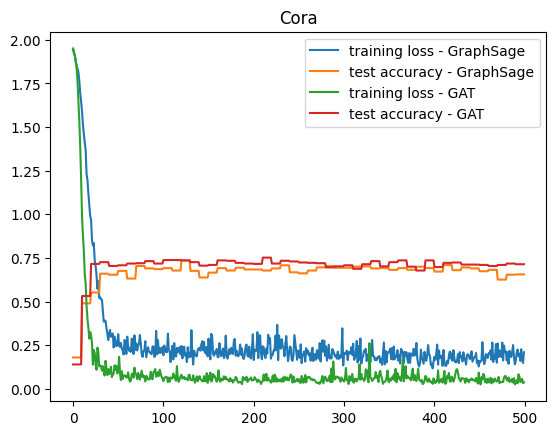

In [9]:
def main():
    for args in [
        {'model_type': 'GraphSage', 'dataset': 'cora', 'num_layers': 2, 'heads': 1, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.01},
    ]:
        args = objectview(args)
        for model in ['GraphSage', 'GAT']:
            args.model_type = model

            # Match the dimension.
            if model == 'GAT':
              args.heads = 2
            else:
              args.heads = 1

            if args.dataset == 'cora':
                dataset = Planetoid(root='/tmp/cora', name='Cora')
            else:
                raise NotImplementedError("Unknown dataset")
            test_accs, losses = train(dataset, args)

            print("Maximum accuracy: {0}".format(max(test_accs)))
            print("Minimum loss: {0}".format(min(losses)))

            plt.title(dataset.name)
            plt.plot(losses, label="training loss" + " - " + args.model_type)
            plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
        plt.legend()
        plt.show()

if __name__ == '__main__':
    main()

# 評分項1: GraphSage（40%）

我們會根據模型表現和實作過程進行分別評分。

We will score according to model's performance and the implementation process.


# 評分項2: GAT（60%）

我們會根據模型表現和實作過程進行分別評分。

We will score according to model's performance and the implementation process.


# 提交 Submission

下載後提交ipynb檔案

Download and submit ipynb file